In [33]:
import pandas as pd
import numpy as np
from plots.Folium_heat import *
from plots.Folium_heat_time import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
df = pd.read_pickle("data/final_final_final_data.pkl")
import matplotlib

# Predictions

The goal of this sections is to see if we can create a model which can predict which Energy Label a building has, based on the the attribute of the building. It will be a multi-class classification problen since we have 7 labels available. If it was possible to achieve high accruacies it would give people the opperitunity see how well their house is doing energy wise, without hiring a company to make the assesment manually. It would also enable people who were looking to buy a house to see how well the house faired energy wise. 

The functions below are used to generate Performance metrics or plots to analyse the model.

In [34]:
def metrics(Y_test,y_pred,x_val,model):
    y_pred=y_pred
    x_val=x_val
    model=model
    auc=round(accuracy_score(Y_test,y_pred),4)
    f_score=round(f1_score(Y_test, y_pred),4)
    P_score=round(precision_score(Y_test,y_pred),4)
    recall=round(recall_score(Y_test, y_pred),4)
    
    ns_probs = [0 for _ in range(len(Y_test))]
    lr_probs = model.predict_proba(x_val)
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(Y_test, ns_probs)
    lr_auc = round(roc_auc_score(Y_test, lr_probs),4)
    return [auc,f_score,P_score,recall,lr_auc]

def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = importance
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df[fi_df.feature_importance > 0.01]
    

    #Define size of bar plot
    plt.figure(figsize=(12,7),dpi=160)
    plt.tight_layout()
    plt.yticks(fontsize=7)
    #Plot Searborn bar chart
    ax=sns.barplot(y='feature_names',x='feature_importance',data=fi_df,palette="rocket")
    ax.set_xlabel('feature_importance')
    #plt.xticks(rotation = 90)
    
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCES > 0.01')
    plt.ylabel('FEATURE NAMES')


def evaluation_time(y_test,y_pred,model,x_val):
    ns_probs = [0 for _ in range(len(y_test))]
    lr_probs = model.predict_proba(x_val)
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print(f"Test set accuracy score {(np.round(accuracy_score(y_pred,y_test),3)*100)}%")
    print(f"F1 score {np.round(f_score,3)}")
    print(f"Recall score {np.round(recall,3)}")
    print(f"Precision score {np.round(P_score,3)}")
    print('Model: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Base')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='XGBoost')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()


Here we make sure that we only keep unique buildings, and take the newest version of the building based on renovations. At the same time we create a binary attribute to indicate wether a building has gone through a bigger renovation.

In [35]:
pred_df = df.drop_duplicates(subset=['addressRepresentation'],keep='last') #Drop duplicates, keep the newest / last row

has_been_rennovated=[]#Binary attribute if a building has been rennovated
for i in range(len(pred_df)):
    if df.dateOfRenovation_dateOfEvent_anyPoint[i] =="other:unpopulated":
        has_been_rennovated.append(0)
    else:
        has_been_rennovated.append(1)
pred_df['has_been_rennovated']=has_been_rennovated
    
    
pred_df

/var/folders/jw/v2qdvl710w5fpqm7sfwqbjkr0000gn/T/ipykernel_53313/1866709111.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['has_been_rennovated']=has_been_rennovated


index  Unnamed: 0  Unnamed: 0.1       id geom  \
1            1           1          1878     1881   GP   
2            2           2          3028     3031   GP   
3            3           3          5733     5736   GP   
4            4           4          8093     8096   GP   
7            7           7        263014   263017  NaN   
...        ...         ...           ...      ...  ...   
123055  106046      106046       5135511  5135514   GP   
123056  106047      106047       4971033  4971036   GP   
123057  106048      106048       4972335  4972338   GP   
123058  106049      106049       4980232  4980235   GP   
123059  106050      106050       5154378  5154381   GP   

                         addressRepresentation     beginLifeSpanVersion  \
1                    Elledamsvej 5, 2840 Holte  2015-01-05T16:29:11.950   
2                    Vejlesøvej 36, 2840 Holte  2015-01-05T17:04:27.490   
3                     Parcelvej 53, 2840 Holte  2015-01-05T16:47:42.557   
4                  Vejlemosevej 4F, 2840 Holte  2016-10-20T16:00:12.350   
7                 Kollemosevej 27A, 2840 Holte      2000-02-05T21:01:47   
...                                        ...                      ...   
123055           Karise Alle 23, 2650 Hvidovre  2017-08-22T14:55:24.737   
123056  Catherine Boothsvej 18D, 2650 Hvidovre  2021-06-30T09:09:41.177   
123057           Stamholmen 156, 2650 Hvidovre  2020-11-26T13:14:05.659   
123058  Catherine Boothsvej 18C, 2650 Hvidovre  2021-07-01T12:19:32.679   
123059            Søvangsvej 17, 2650 Hvidovre  2018-04-24T16:18:08.753   

       buildingNature conditionOfConstruction    connectionToGas  ...  \
1               other              functional  other:unpopulated  ...   
2               other              functional  other:unpopulated  ...   
3               other              functional  other:unpopulated  ...   
4               other              functional  other:unpopulated  ...   
7               other              demolished  other:unpopulated  ...   
...               ...                     ...                ...  ...   
123055  storage  Tank              demolished  other:unpopulated  ...   
123056          other     under  Construction  other:unpopulated  ...   
123057          other     under  Construction  other:unpopulated  ...   
123058          other     under  Construction  other:unpopulated  ...   
123059  storage  Tank              functional  other:unpopulated  ...   

       Antal til salg pr. indbygger Gennemsnitslig husleje Kommuneskat  \
1                            0.0107                    936      0.3521   
2                            0.0107                    936      0.3521   
3                            0.0107                    936      0.3521   
4                            0.0107                    936      0.3521   
7                            0.0107                    936      0.3521   
...                             ...                    ...         ...   
123055                       0.0030                    895      0.3837   
123056                       0.0030                    895      0.3837   
123057                       0.0030                    895      0.3837   
123058                       0.0030                    895      0.3837   
123059                       0.0030                    895      0.3837   

       Grundskyld Bruttoledige     Gæld Pensionsopsparing  \
1         22.930‰       0.0817  1806779           1772259   
2         22.930‰       0.0817  1806779           1772259   
3         22.930‰       0.0817  1806779           1772259   
4         22.930‰       0.0817  1806779           1772259   
7         22.930‰       0.0817  1806779           1772259   
...           ...          ...      ...               ...   
123055    29.700‰       0.1096   679388            830552   
123056    29.700‰       0.1096   679388            830552   
123057    29.700‰       0.1096   679388            830552   
123058    29.700‰       0.1096   67

Due to the sheer size of our data set, espacially in terms of the number of categorical data we must select a subset of our attributes to create the model on, to reduce the run time. After a trial and error proces and manually selecting columns which does not contain a lot of missing values, the following attributes below has been found. Most of them are self explanatory from the name.

In [56]:
X,y=[         'connectionToSewage', 
              'connectionToWater',
              'currentUse',
              'dateOfRenovation_dateOfEvent_anyPoint', #When the house was rennovated
              'HeatSupply',
              'materialOfRoof',
              'materialOfWall',
              'YearOfConstruction_Interval', #Intervals of 10 years
              #'has_been_rennovated', All have been rennovated
              'officialArea' #Area of house in square meteres
              ],['EnergyLabelClassification']

We can now create our data set our final dataset for predictions, with our attributes X and target attribute Y - the Energy labels. All of our attributes in X but "offical Area" are categorical and will be dummy encoded in order for our model to be able to handle them. The final result is 71723 buildings and 67 attributes describing them, we for training and predicitng with our model.

In [37]:
pred_df=pred_df.sort_values(by=['EnergyLabelClassification'])
y=pred_df[y].values
x=pred_df[X]
x=pd.get_dummies(x)
labels=list(x.columns)
x=x.values
scaler = StandardScaler()
x=scaler.fit_transform(x)
print(np.shape(x))

(71723, 67)


We split our data set in a ratio 80/20 to a train and test set, and shuffle it randomly. Then we apply the tree based ensamble model XGBOOST classifier model to the data with default hyperparameter values.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

model_xg = XGBClassifier(objective ='binary:logistic',verbosity = 0,silent=True)
model_xg.fit(X_train, y_train)
y_pred = model_xg.predict(X_test) #Collapsed due to label warning from XGpackage

/Users/martinillum/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/martinillum/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Right out of the box the model scores 46,8% which would be a fairly accuracy for a binaray classification problem, however since this is a multi classification problem of 7 classes it becomes more manageable. Lets see if we can increase the performance by tuning the hyper parameters. The Hyperparameters and their definitions can be found [here](https://xgboost.readthedocs.io/en/stable/parameter.html )

In [13]:
print(f"Test set accuracy score {(np.round(accuracy_score(y_pred,y_test),3)*100)}%")

Test set accuracy score 46.800000000000004%


### Hyperparamter tuning

We will be using random search to find the optimize our hyperparameters. By using random search we will most likely not find the optimal combination, however we will reduce the running time significantly compared to a grid search.

In [14]:
params = {
 "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
 "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

In [15]:
rs_model=RandomizedSearchCV(model_xg,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=0)
rs_model.fit(X_train,y_train)

/Users/martinillum/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/martinillum/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/martinillum/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encode

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           gpu_id=-1, importance_type='gain',
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constraints='()',
                                           n_estimators=100, n_jobs=8,
                                           num_pa...
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_p

The optimal hyperparameters are found to be:

In [12]:
rs_model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, silent=True, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

The hyperparameters are fitted and the accuracy score is calculated to 46.7% We can see that the model performance is basically the same, just 0.1 lower which is not optimal, however since random search is a random process, this can happen

In [13]:
y_pred = rs_model.predict(X_test)
print(f"Test set accuracy score {(np.round(accuracy_score(y_pred,y_test),3)*100)}%")

Test set accuracy score 46.7%


Wether 46.7% is good accuracy for 7 classes depends on the class representation of our taget attribute. Below a heatmap of the confusion matrix of all classes is plotted:

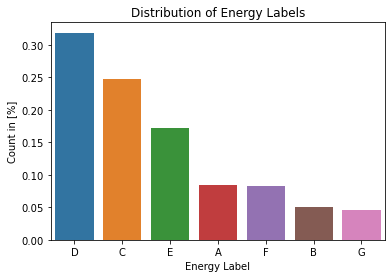

In [32]:
sns.barplot(x=pred_df.EnergyLabelClassification.value_counts().index,
            y=pred_df.EnergyLabelClassification.value_counts(normalize=True),
)
plt.title("Distribution of Energy Labels")
plt.xlabel("Energy Label")
plt.ylabel("Count in [%]");

It is clear that the energylabel D rerpresents roughly 33% of all cases, so if we were to take guess at C everytime we could reach an accuracy of 33% which our model is supirior too. However lets have a deeper look into the predictions. It is very interessant wether of model predicts G when it is in reality an A. Or if it just predicts one label to high or too low. This will be illustrated in the Heatmap of the confusion matrix below:

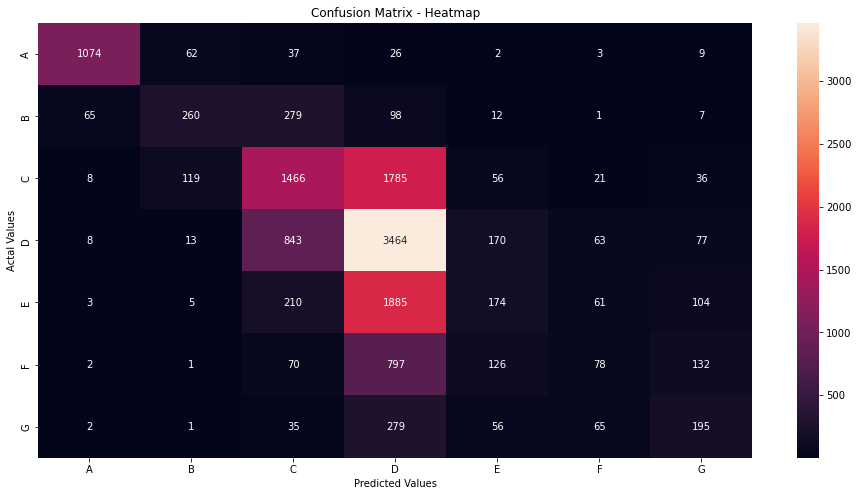

In [34]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = sorted(list(df.EnergyLabelClassification.unique())), 
                     columns = sorted(list(df.EnergyLabelClassification.unique())))
#Plotting the confusion matrix
plt.figure(figsize=(16,8))
sns.heatmap(cm_df, annot=True,fmt='g')
plt.title('Confusion Matrix - Heatmap')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

The rule of thumb here is that we cells in the diagonal to be the brightest, and the cells just around them if that is not the case. We can quickly see that our model is really good at Predicting energyLabels of "A", "G" and it rarely confuses it with  another class. We we look at the classes C & D the model has a hard time differentiating between the classes, espacially the value D.

Lets have a further look at which attribute plays the biggest role for the prediction based on impurity / Gain

Its clear to see that the most important attribute for the energylabel is the heating source of the house and what year it is built. We saw in the exploratory analysis that the heating source varied a lot depending which municipality the hous was located in of greater copenhagen. It can also be assummed that the attributes "Materials of walls" and "material of roofs" might be highly correlated to the "Year of construction interval", because certain materials for builting was used in different decades.

Over all the model is not fantastic, however it will give a good approximation on the energylabel + - one catergory level. There are several things that could be done to improve it, more data of actual energy usage, adding a K-nearest neighbhour model to compare a bulding with it K nearest neighbhours.

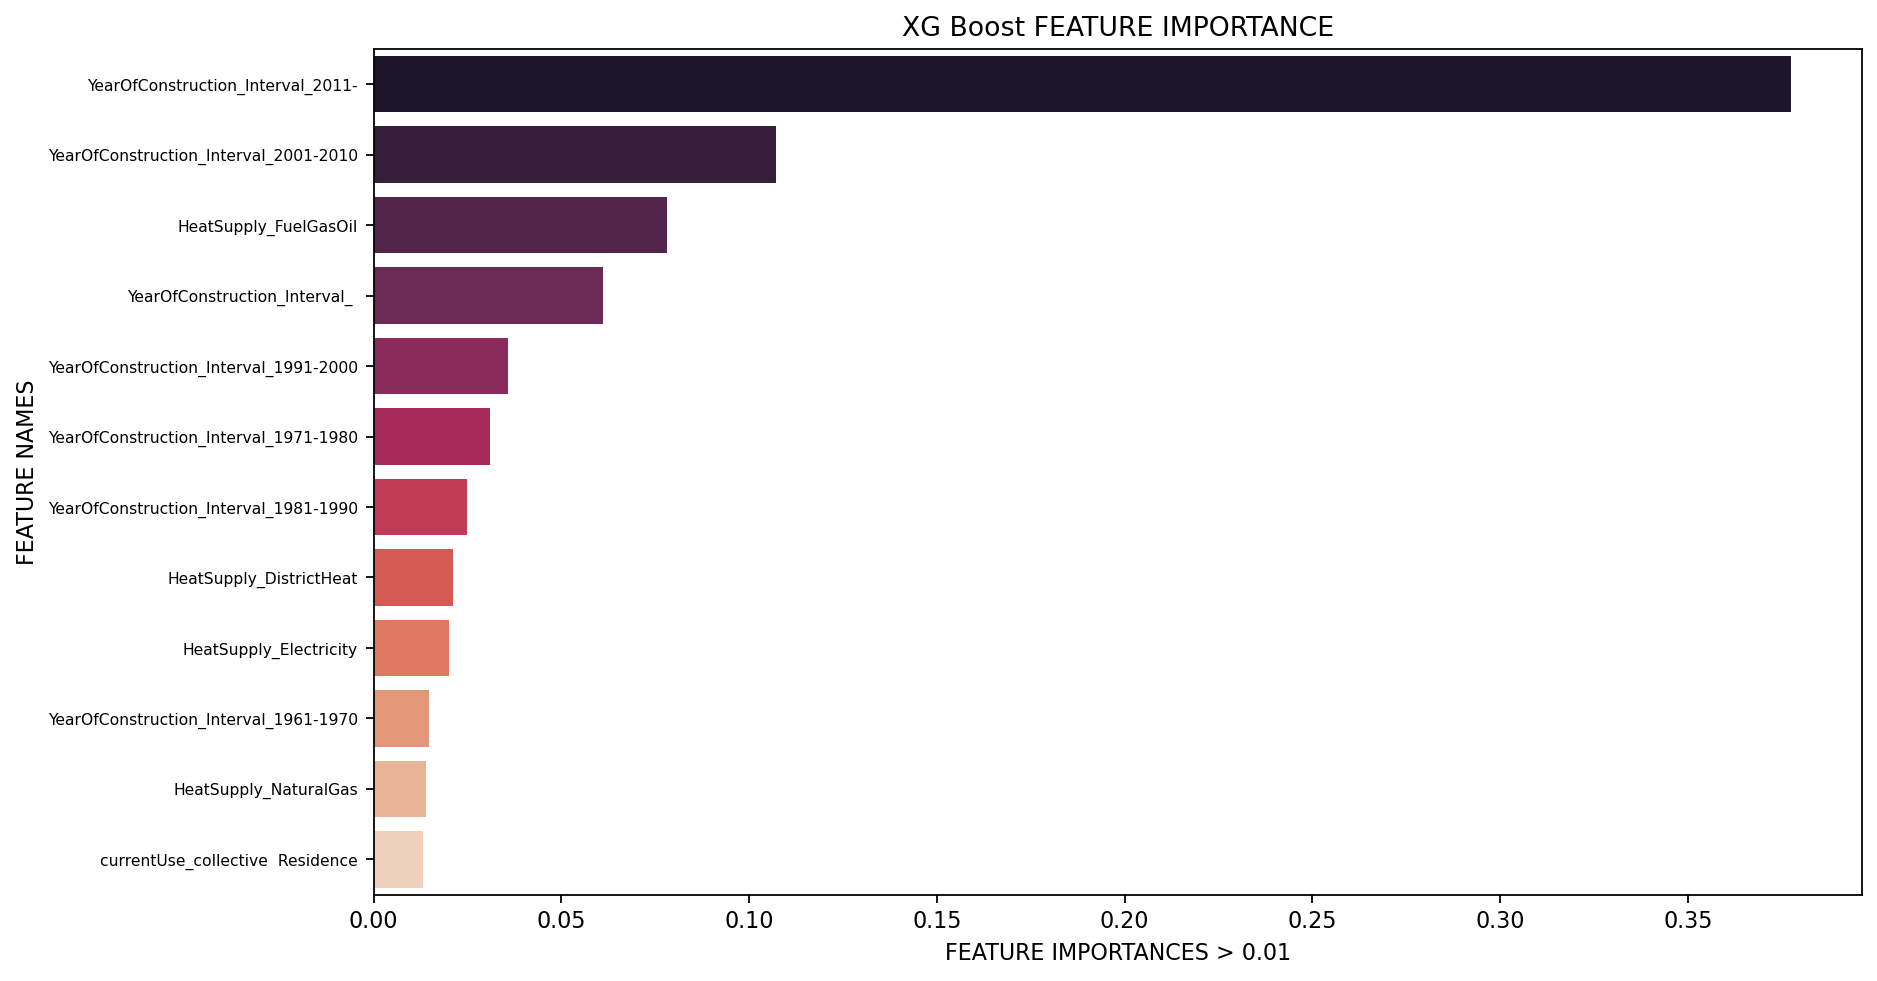

In [35]:
plot_feature_importance(model_xg.feature_importances_,labels,"XG Boost")

## Animation Plot

In [4]:
df

index  Unnamed: 0  Unnamed: 0.1       id geom  \
0            0           0          1878     1881   GP   
1            1           1          1878     1881   GP   
2            2           2          3028     3031   GP   
3            3           3          5733     5736   GP   
4            4           4          8093     8096   GP   
...        ...         ...           ...      ...  ...   
123055  106046      106046       5135511  5135514   GP   
123056  106047      106047       4971033  4971036   GP   
123057  106048      106048       4972335  4972338   GP   
123058  106049      106049       4980232  4980235   GP   
123059  106050      106050       5154378  5154381   GP   

                         addressRepresentation     beginLifeSpanVersion  \
0                    Elledamsvej 5, 2840 Holte  2015-01-05T16:29:11.950   
1                    Elledamsvej 5, 2840 Holte  2015-01-05T16:29:11.950   
2                    Vejlesøvej 36, 2840 Holte  2015-01-05T17:04:27.490   
3                     Parcelvej 53, 2840 Holte  2015-01-05T16:47:42.557   
4                  Vejlemosevej 4F, 2840 Holte  2016-10-20T16:00:12.350   
...                                        ...                      ...   
123055           Karise Alle 23, 2650 Hvidovre  2017-08-22T14:55:24.737   
123056  Catherine Boothsvej 18D, 2650 Hvidovre  2021-06-30T09:09:41.177   
123057           Stamholmen 156, 2650 Hvidovre  2020-11-26T13:14:05.659   
123058  Catherine Boothsvej 18C, 2650 Hvidovre  2021-07-01T12:19:32.679   
123059            Søvangsvej 17, 2650 Hvidovre  2018-04-24T16:18:08.753   

       buildingNature conditionOfConstruction    connectionToGas  ...  \
0               other              functional  other:unpopulated  ...   
1               other              functional  other:unpopulated  ...   
2               other              functional  other:unpopulated  ...   
3               other              functional  other:unpopulated  ...   
4               other              functional  other:unpopulated  ...   
...               ...                     ...                ...  ...   
123055  storage  Tank              demolished  other:unpopulated  ...   
123056          other     under  Construction  other:unpopulated  ...   
123057          other     under  Construction  other:unpopulated  ...   
123058          other     under  Construction  other:unpopulated  ...   
123059  storage  Tank              functional  other:unpopulated  ...   

       Kvadratmeterpris Antal til salg pr. indbygger Gennemsnitslig husleje  \
0                 37466                       0.0107                    936   
1                 37466                       0.0107                    936   
2                 37466                       0.0107                    936   
3                 37466                       0.0107                    936   
4                 37466                       0.0107                    936   
...                 ...                          ...                    ...   
123055            30356                       0.0030                    895   
123056            30356                       0.0030                    895   
123057            30356                       0.0030                    895   
123058            30356                       0.0030                    895   
123059            30356                       0.0030                    895   

       Kommuneskat Grundskyld Bruttoledige     Gæld  Pensionsopsparing  \
0           0.3521    22.930‰       0.0817  1806779            1772259   
1           0.3521    22.930‰       0.0817  1806779            1772259   
2           0.3521    22.930‰       0.0817  1806779            1772259   
3           0.3521    22.930‰       0.0817  1806779            1772259   
4           0.3521    22.930‰       0.0817  1806779            1772259   
...            ...        ...          ...      ...                ...   
123055      0.3837    29.700‰       0.1096   679388             830

In [5]:
def update(df, date):
    # Filters dataframe to rows at the date
    data = df[df['date']]

    # Assigns filtered data to x,y variables
    x = data['state']
    y = data['cases']

    # Creates matplotlib figure and axes to plot graph
    fig, ax = matplotlib.pyplot.subplots(1,1,figsize=(9, 6))
    ax.bar(x, y)

    # Adds figure title as the date of that iteration
    fig.suptitle(date)

In [8]:
df.YearOfConstruction
df['Year of construction'] = pd.to_datetime(df['YearOfConstruction'])

In [11]:
df=df.sort_values(by=['Year of construction'])

In [14]:
anim = matplotlib.animation.FuncAnimation(
    fig=fig,
    func=update,
    frames=date_list,
    interval=100,
    repeat=True,
    repeat_delay=2000
)

anim.save(local_path+'myanim.gif')

NameError: name 'fig' is not defined

In [21]:
pred_df[X].columns

Index(['connectionToSewage', 'connectionToWater', 'currentUse',
       'dateOfRenovation_dateOfEvent_anyPoint', 'HeatSupply', 'materialOfRoof',
       'materialOfWall', 'YearOfConstruction_Interval', 'has_been_rennovated',
       'officialArea'],
      dtype='object')

In [57]:
Columns_and_value = []
for i in range(len(pred_df[X].columns)):
    if pred_df[X].columns[i] not in ['dateOfRenovation_dateOfEvent_anyPoint','officialArea']:   
        value=pred_df[X].columns[i]
        Columns_and_value.append([value,list(pred_df[value].value_counts().index)])
    else:
        value=pred_df[X].columns[i]
        Columns_and_value.append([value,"Continous INT"])


In [58]:
Columns_and_value

[['connectionToSewage', ['true', 'other:unpopulated', 'false']],
 ['connectionToWater', ['true', 'other:unpopulated', 'false']],
 ['currentUse',
  ['individual  Residence',
   'collective  Residence',
   'other:unpopulated',
   'public  Services',
   'two  Dwellings',
   'office',
   'trade',
   'commerce  And  Services',
   'agriculture',
   'residence  For  Communities',
   'industrial',
   '  Unknown',
   'residential']],
 ['dateOfRenovation_dateOfEvent_anyPoint', 'Continous INT'],
 ['HeatSupply',
  ['DistrictHeat',
   'NaturalGas',
   'FuelGasOil',
   'Electricity',
   'WoodPellets',
   'FuelOil',
   'CityGas',
   'Wood',
   'Petroleum',
   'WoodChips',
   'Biogas',
   'Briquettes']],
 ['materialOfRoof',
  ['clay  Tile',
   'concrete  Tile',
   'hot  Mopped  Asphalt',
   'other:unpopulated',
   'composition',
   'other',
   'corrugated  Sheet',
   'glass',
   'thatch',
   'vegetated  Green  Roof',
   'none']],
 ['materialOfWall',
  ['masonry',
   'other:unpopulated',
   'concrete',